In [3]:
#np.random.seed(0)
import keras
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv1D, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback
from keras.datasets import mnist
from keras import backend as K
from keras.initializers import VarianceScaling
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/My Drive/Colab\ Notebooks/titanic

/content/drive/My Drive/Colab Notebooks/titanic


In [ ]:
ls

'github projects.ipynb'   test.csv   train.csv


# Warm Up:

Analyzing the **"Titanic"** data-set on Kaggle. The problem is, *use machine learning to create a model that predicts which passengers survived the Titanic shipwreck, based on information available about the passengers.*

##### Here I begin modeling using **RandomForest** classification

## Importing data files placed in the present directory

In [ ]:
train_data = pd.read_csv("train.csv")
#train_data = train_data.dropna(axis=0)

test_data = pd.read_csv("test.csv")
#test_data = test_data.dropna(axis=0)

train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Determining basic stat about different features present in data-set

In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


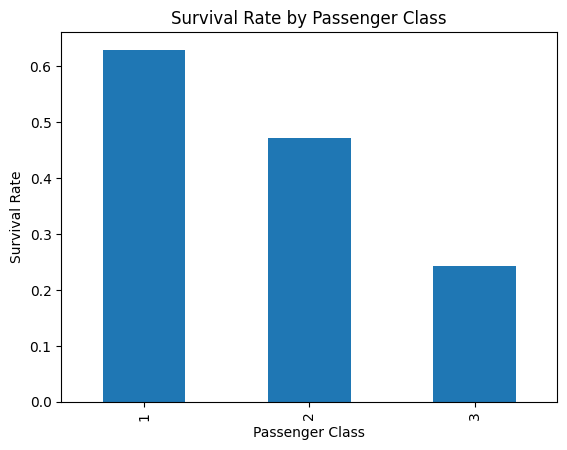

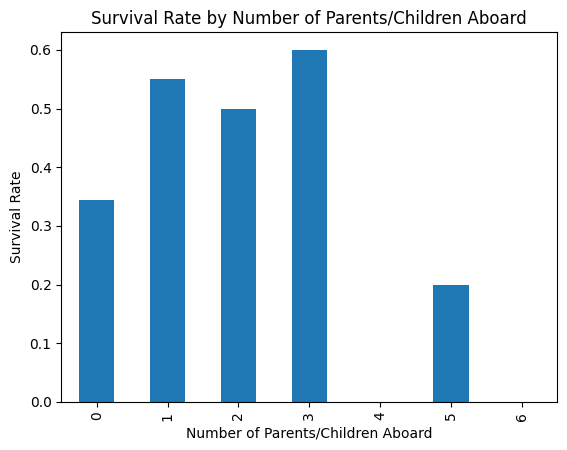

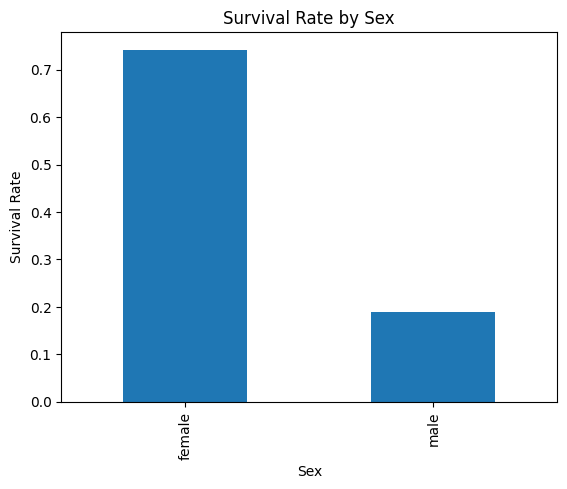

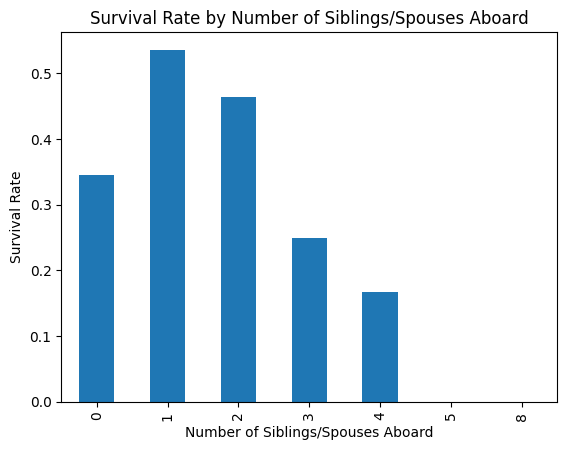

In [ ]:
import matplotlib.pyplot as plt

# 'pclass' vs 'Survived'
plt.figure()
train_data.groupby('Pclass')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

# 'parch' vs 'Survived'
plt.figure()
train_data.groupby('Parch')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Number of Parents/Children Aboard')
plt.xlabel('Number of Parents/Children Aboard')
plt.ylabel('Survival Rate')

# 'Sex' vs 'Survived'
plt.figure()
train_data.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')

# 'SibSp' vs 'Survived'
plt.figure()
train_data.groupby('SibSp')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Number of Siblings/Spouses Aboard')
plt.xlabel('Number of Siblings/Spouses Aboard')
plt.ylabel('Survival Rate')

plt.show()


## Processing for appropriate feature representation

In [ ]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [ ]:
train_data['Sex']=train_data['Sex'].map({'female': 1, 'male': 0}) # Changing string values in 'Sex' column to integer values
test_data['Sex']=test_data['Sex'].map({'female': 1, 'male': 0})

train_data.head()

features=['Pclass','Sex', 'SibSp','Parch'] # These are the only features with numeric values which has no-NaN in any entry

X_train=train_data[features]
print(X_train.head())
y_train=train_data['Survived']

X_test=test_data[features]

   Pclass  Sex  SibSp  Parch
0       3    0      1      0
1       1    1      1      0
2       3    1      0      0
3       1    1      1      0
4       3    0      0      0


In [ ]:
#Xtrain_array=X_train.to_numpy(dtype='object')

def feature_reps(X_train):

  #One-hot encoding for 'Sex' Column
  one_hot = pd.get_dummies(X_train['Sex'])
  X_train = X_train.drop('Sex',axis = 1)
  X_train = X_train.join(one_hot)

  # Normalizing 'Age' Column
  #XAge=X_train['Age']
  #X_train['Age']=(XAge-XAge.mean())/XAge.std()

  # Normalizing 'Fare' Column
  #XFare=X_train['Fare']
  #X_train['Fare']=(XFare-XFare.mean())/XFare.std()

  X_train['SibSp']=X_train['SibSp']/max(X_train['SibSp'])
  X_train['Parch']=X_train['Parch']/max(X_train['Parch'])
  X_train['Pclass']=X_train['Pclass']/max(X_train['Pclass'])

  return X_train

X_train=feature_reps(X_train)
X_train.columns = X_train.columns.astype(str) # Converts the one-hot added column names from int to str
X_train.head()

X_test=feature_reps(X_test)
X_test.columns = X_test.columns.astype(str)


## Fit the data using **RandomForest**, after optimizing some hyperparameters.

In [ ]:
# Get some representative hyperparameters of the base fitted model

from pprint import pprint

rf_model = RandomForestClassifier(random_state=1)
#pprint(rf_model.get_params())
rf_model.fit(X_train, y_train)
#print('\n')

tree_depths = [tree.get_depth() for tree in rf_model.estimators_]
print("Maximum Depth of Trees:", max(tree_depths))
print("Number of Trees:", len(tree_depths))

Maximum Depth of Trees: 11
Number of Trees: 100


In [ ]:
# make a "random_grid" of values of the hyperparameters and try random combinations using
# "RandomizedSearchCV", to find the optimized combination.

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 250, num = 25)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_ # Get the best performing combination of parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 5,
 'bootstrap': True}

### Fit the optimized model using Training data, and make predictions on test-data

In [ ]:
rf = RandomForestClassifier(n_estimators=75, min_samples_split=2, min_samples_leaf=4, max_depth=5, bootstrap=False)
rf.fit(X_train, y_train)
ytest_pred = rf.predict(X_test)

### The above model **scored ~ 0.76** (out of 1) on *Kaggle*.